In [110]:
import sys

sys.path.append("../../..")

import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib import rc
import mpl_toolkits.axes_grid1.inset_locator as inloc
import scipy.stats as stats
import src.energy_effects_t2k.convolution as conv
import src.nu_osc.osc_prob as osc
import src.nu_osc.default_parameters as param
from numba import jit

In [111]:
rc("figure", figsize=(10, 5))
# rc('lines', linewidth=2)
rc("axes", labelsize=12, linewidth=1, grid=True, labelpad=-1, axisbelow=True)
rc("axes.spines", right=True)
rc("xtick", direction="in", labelsize=12, top=True)
rc("xtick.major", width=0.8, size=5)
rc("ytick", direction="in", labelsize=12, right=True)
rc("ytick.major", width=0.8, size=5)
rc("legend", fancybox=False, fontsize=12, shadow=False)
rc(
    "grid",
    linewidth=1.0,
)  # ls='dotted')
# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [112]:
colors = {
    "numu": "darkgreen",
    "antinumu": "darkseagreen",
    "nue": "red",
    "antinue": "rosybrown",
    "nutau": "teal",
    "antinutau": "cadetblue",
}

In [113]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [114]:
def line(x, α, β):
    return α + x * β


rng = np.random.default_rng(1)
data_x = np.linspace(0, 1, 10)
data_yerr = 0.1
data_y = rng.normal(line(data_x, 1, 2), data_yerr)

In [115]:
least_squares = LeastSquares(data_x, data_y, data_yerr, line)

m = Minuit(least_squares, α=0, β=0)

m.limits = [(0, 2), (0, 3)]

# m.errordef = Minuit.LIKELIHOOD

m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.959 (χ²/ndof = 0.5)      │              Nfcn = 109              │
│ EDM = 1.21e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   1.02    │   0.06    │            │            │    0    │    2    │       │
│ 1 │ β    │    2.0    │    0.1    │            │            │    0    │    3    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       α       β │
├───┼─────────────────┤
│ α │ 0.00345 -0.0049 │
│ β │ -0.0049 0.00982 │
└───┴─────────────────┘

In [116]:
t2kflux_2020_plus250kA_nominal_sk = conv.fluximport(
    "t2kflux_2020_plus250kA_nominal_sk.csv"
)

ccqe_interp = conv.xsecimport(
    name="neutrino_ccqe.csv",
    mode="true filter interp",
    keep_left=5,
    on=(t2kflux_2020_plus250kA_nominal_sk.minE + t2kflux_2020_plus250kA_nominal_sk.maxE)
    / 2,
)

ccqe_energy_res_interp = conv.energyimport(
    name="ccqe_energy_res.csv", mode="interp", on=np.linspace(-0.5, 1.0, 125)
)

number = pd.DataFrame()
for key in ["minE", "maxE"]:
    number[key] = t2kflux_2020_plus250kA_nominal_sk[key]
for key in ["numu", "antinumu", "nue", "antinue"]:
    number[key] = (
        (ccqe_interp.xsec * t2kflux_2020_plus250kA_nominal_sk[key] / (50 * 1e21))
        * param.SK_POT["FHC"]
        * param.TOT_NEUTRONS
        * 2
    )
number["nutau"] = 0.0
number["antinutau"] = 0.0


def sk_hist(
    θ23=param.NUFIT["theta_23"]["bf"],
    δCP=param.NUFIT["delta_CP"]["bf"],
    Δ2m32=param.NUFIT["Dm_square_32"]["bf"],
):
    return conv.convolve(
        conv.oscillate(to_oscillate=number, theta_23=θ23, delta_cp=δCP, dm2_atm=Δ2m32),
        gate=ccqe_energy_res_interp,
    )

In [117]:
sk_hist_bf = sk_hist()

In [118]:
def t2k_likelihood(θ23, δCP, Δ2m32):
    sk_hist_obs = sk_hist(θ23=θ23, δCP=δCP, Δ2m32=Δ2m32)
    sk_hist_exp = sk_hist()
    N_obs = sk_hist_obs["numu"] * (sk_hist_obs.maxE - sk_hist_obs.minE) * 1e3
    N_exp = sk_hist_exp["numu"] * (sk_hist_exp.maxE - sk_hist_exp.minE) * 1e3
    l = (N_exp - N_obs + N_obs * np.log(N_obs / N_exp)).sum()
    return l

In [119]:
t2k_likelihood(
    θ23=param.NUFIT["theta_23"]["bf"],
    δCP=param.NUFIT["delta_CP"]["bf"],
    Δ2m32=-param.NUFIT["Dm_square_32"]["bf"],
)

0.25582597706917937

In [ ]:
some_bin = np.linspace(0e-3, 10e-3, 100)

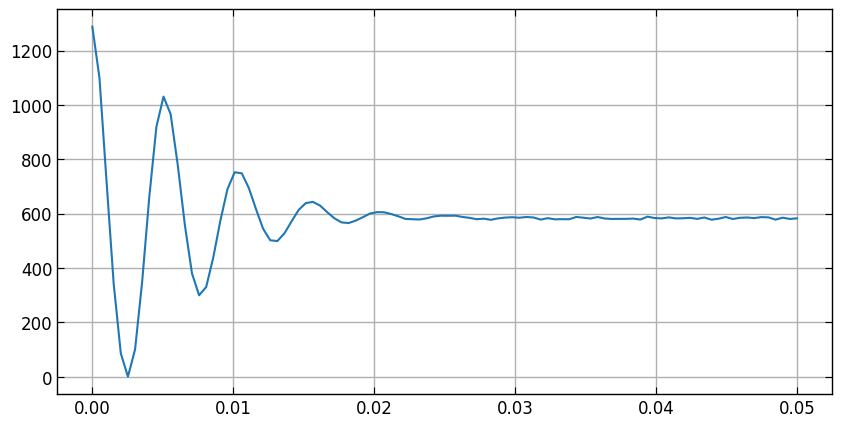

In [ ]:
plt.plot(
    some_bin,
    [
        t2k_likelihood(
            θ23=param.NUFIT["theta_23"]["bf"],
            δCP=param.NUFIT["delta_CP"]["bf"],
            Δ2m32=x,
        )
        for x in some_bin
    ],
)

plt.show()

In [120]:
t2k_likelihood.errordef = Minuit.LIKELIHOOD

In [121]:
m = Minuit(
    t2k_likelihood,
    θ23=param.NUFIT["theta_23"]["bf"],
    δCP=param.NUFIT["delta_CP"]["bf"],
    Δ2m32=1e-3,
)

In [122]:
# m.fixed["θ23"] = True
m.fixed["δCP"] = True

In [123]:
m.limits = [(0, 2 * np.pi), (-np.pi, np.pi), (0, 5e-3)]

In [124]:
# m.errors = 1e-6

In [125]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,θ23,0.738,0.007,,,0,6.28,
1,δCP,3.14,0.04,,,-3.14,3.14,yes
2,Δ2m32,1.00e-3,0.01e-3,,,0,0.005,


In [126]:
m.migrad()
m.hesse()
# m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.288e-06                  │              Nfcn = 52               │
│ EDM = 2.83e-07 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ θ23   │   0.738   │   0.027   │            │            │    0    │ 6.28319 │       │
│ 1 │ δCP   │   3.14    │   0.04    │            │            │-3.14159 │ 3.14159 │  yes  │
│ 2 │ Δ2m32 │  2.51e-3  │  0.05e-3  │            │            │    0    │  0.005  │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │      θ23      δCP    Δ2m32 │
├───────┼────────────────────────────┤
│   θ23 │ 0.000703        0 -45.2e-9 │
│   δCP │        0        0        0 │
│ Δ2m32 │ -45.2e-9        0 2.58e-09 │
└───────┴────────────────────────────┘

KeyboardInterrupt: 

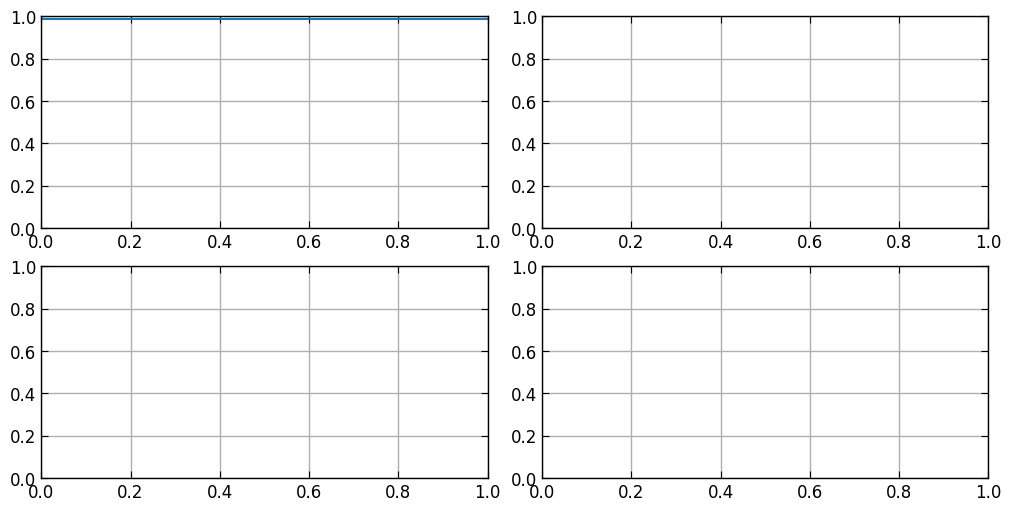

In [127]:
m.draw_mnmatrix()

(array([0.0024319 , 0.00243694, 0.00244198, 0.00244702, 0.00245206,
        0.0024571 , 0.00246214, 0.00246719, 0.00247223, 0.00247727,
        0.00248231, 0.00248735, 0.00249239, 0.00249743, 0.00250247,
        0.00250751, 0.00251255, 0.00251759, 0.00252264, 0.00252768,
        0.00253272, 0.00253776, 0.0025428 , 0.00254784, 0.00255288,
        0.00255792, 0.00256296, 0.002568  , 0.00257304, 0.00257809]),
 array([1.99221177e+00, 1.72715028e+00, 1.48090618e+00, 1.25349072e+00,
        1.04491873e+00, 8.55208367e-01, 6.84380315e-01, 5.32456827e-01,
        3.99460592e-01, 2.85413630e-01, 1.90336298e-01, 1.14246459e-01,
        5.71588278e-02, 1.90844878e-02, 3.05597080e-05, 0.00000000e+00,
        1.89915161e-02, 5.69995892e-02, 1.14014606e-01, 1.90023111e-01,
        2.85008186e-01, 3.98949979e-01, 5.31826391e-01, 6.83613895e-01,
        8.54288469e-01, 1.04382656e+00, 1.25220601e+00, 1.47940671e+00,
        1.72541109e+00, 1.99020419e+00]))

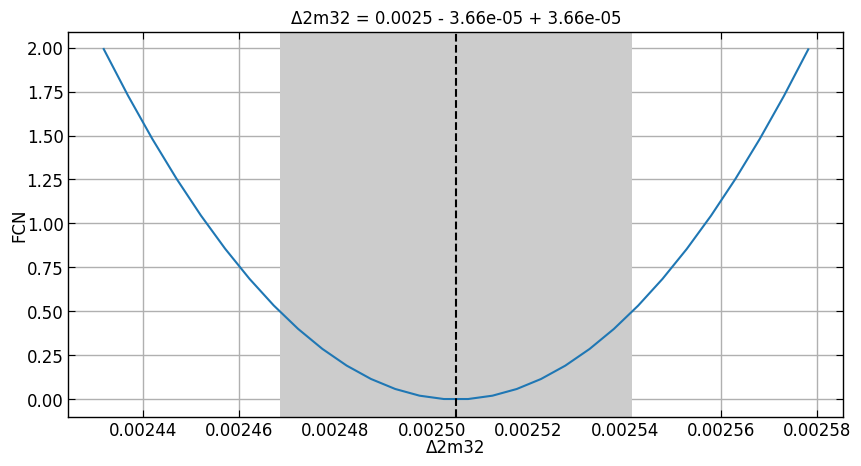

In [ ]:
m.draw_mnprofile("Δ2m32")

In [ ]:
sk_hist_fit = sk_hist(*m.values)

In [ ]:
m.values

<ValueView θ23=0.738269228562493 δCP=4.049163864626845 Δ2m32=0.00250583852804363>

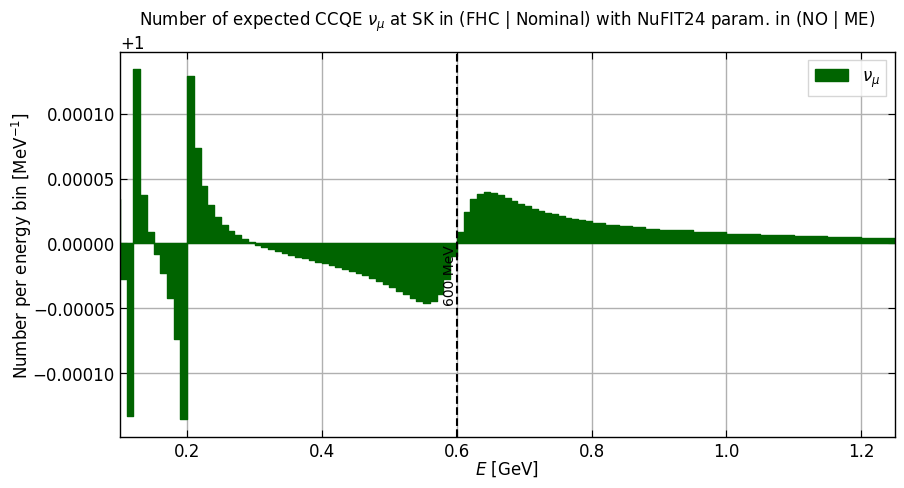

In [ ]:
for key in ["numu"]:
    plt.fill_between(
        sk_hist_bf.minE,
        sk_hist_fit[key] / sk_hist_bf[key],
        1,
        label=conv.print_dict[key],
        color=colors[key],
        step="post",
        # alpha=.5,
        # linestyle='--',
    )


plt.axvline(x=0.6, linestyle="--", color="black")
ax = plt.gca()
plt.text(
    x=0.6,
    y=0.5,
    s=r"600 MeV",
    ha="right",
    va="top",
    rotation=90,
    transform=ax.get_xaxis_transform(),
)

# plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"$E$ [GeV]")
plt.ylabel(r"Number per energy bin [$\text{MeV}^{-1}$]")
# plt.ylim(bottom=1e-1)
plt.xlim([0.1, 1.25])
plt.title(
    r"Number of expected CCQE $\nu_\mu$ at SK in (FHC | Nominal) with NuFIT24 param. in (NO | ME)"
)
plt.legend()

plt.show()